# First Phase-Autoencoder

In [ ]:
seed = 0
import random
random.seed(seed)
import numpy as np
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/My Drive/methylation')

Mounted at /content/drive/


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorflow_version 1
#Start tensorboard
%tensorboard — logdir logs
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter('ignore')

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--host ADDR]
                   [--port PORT] [--purge_orphaned_data BOOL] [--db URI]
                   [--db_import] [--inspect] [--version_tb] [--tag TAG]
                   [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_channel ADDR]
                   [--whatif-use-unsafe-custom-prediction YOUR_CUSTOM_PREDICT_FUNCTION.py]
                   [--whatif-data-dir PATH]
tensorboard: error: unrecognized ar

In [ ]:
%matplotlib inline  

import imp
import numpy as np
import os
import keras
import keras.backend
import keras.models
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras import regularizers
from keras.models import Model,Sequential
from keras.layers import Input,Dense,Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, Adadelta
from keras.utils import plot_model
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import keras.models as mod
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import TensorBoard
from sklearn.externals import joblib

Using TensorFlow backend.


In [ ]:
seed=0    #Initially 0
np.random.seed(seed)

df = pd.read_csv('dataset/genelevelMethyl.csv', index_col=0)
df = df.reindex(sorted(df.columns), axis=1)
df=df.T
print("CNV Matrix Before:", df.shape)

df2=pd.read_csv('dataset/BRCA_clinicalMatrix.gz',compression='gzip',sep='\t',index_col=0)
df2.index = pd.Series({x: x.replace('-', '.') for x in df2.index})
print("Clinical Data Before:", df2.shape)
k=df2.columns.get_loc('PAM50Call_RNAseq')
df2=df2[df2.iloc[:,k].isna()==False]

commonIndexes=np.sort(list(set(df2.index).intersection(set(df.index)))) 
df=df.loc[commonIndexes]
df2=df2.loc[commonIndexes] 

print("CNV After:", df.shape)
print("Clinical Data After:", df2.shape)
unique_elements, counts_elements = np.unique(df2.iloc[:,k], return_counts=True)
print("Labels", unique_elements, counts_elements)

CNV Matrix Before: (888, 22382)
Clinical Data Before: (1247, 202)
CNV After: (620, 22382)
Clinical Data After: (620, 202)
Labels ['Basal' 'Her2' 'LumA' 'LumB' 'Normal'] [ 87  31 288 127  87]


In [ ]:
X=np.array(df.values)

print(X.mean(axis = 0), X.std(axis = 0))

[0.74493477 0.11909509 0.12293918 ... 0.02458532 0.02334496 0.02953317] [0.11246621 0.06753688 0.08329447 ... 0.00518287 0.00536418 0.00512363]


In [ ]:
X.shape

(620, 22382)

In [ ]:
X_train = X

In [ ]:
Y_temp=np.array(df2.values[:,k])
print("TARGET LABEL SIZE BEFORE: ", Y_temp.shape)
label_encoder=LabelEncoder()
Y=label_encoder.fit_transform(Y_temp)
print("TARGET LABEL SIZE BEFORE: ", Y.shape)
print("Labels before and after:", Y_temp[0:9], Y[0:9])
le_name_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_name_mapping)

TARGET LABEL SIZE BEFORE:  (620,)
TARGET LABEL SIZE BEFORE:  (620,)
Labels before and after: ['Normal' 'LumA' 'LumA' 'LumA' 'LumA' 'LumB' 'LumA' 'Basal' 'LumA'] [4 2 2 2 2 3 2 0 2]
{'Basal': 0, 'Her2': 1, 'LumA': 2, 'LumB': 3, 'Normal': 4}


In [ ]:
Y_train = Y.reshape(len(Y), 1)
Y_train.shape

(620, 1)

In [ ]:
sm = SMOTE(random_state=seed)
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=seed)
print('Train Set before SMOTE:', X_train.shape, Y_train.shape)
X_train_sm, Y_train_sm = sm.fit_sample(X_train, Y_train)
print('Train Set after SMOTE:', X_train_sm.shape, Y_train_sm.shape)
#print('Validation Set:', X_val.shape, Y_val.shape)

Train Set before SMOTE: (620, 22382) (620, 1)
Train Set after SMOTE: (1440, 22382) (1440,)


In [ ]:

seed = 0
input_dim=X_train.shape[1]
encoding_dim=500

from keras.layers import ReLU


input_layer1=Input(shape=(input_dim,),name='Original Input')

hidden2=Dense(5000,activation=None,name='dense_100', activity_regularizer=regularizers.l2(10e-15))(input_layer1)
relu1 = ReLU()(hidden2)

hidden4=Dense(2000,activation=None,name='dense_101', activity_regularizer=regularizers.l2(10e-15))(relu1)
relu2 = ReLU()(hidden4)

hidden10=Dense(encoding_dim,activation=None,name='dense_105', activity_regularizer=regularizers.l2(10e-15))(relu2)
relu3 = ReLU()(hidden10)

hidden8=Dense(2000,activation=None,name='dense_103', activity_regularizer=regularizers.l2(10e-15))(relu3)
relu4 = ReLU()(hidden8)
hidden9=Dense(5000,activation=None,name='dense_104', activity_regularizer=regularizers.l2(10e-15))(relu4)
relu5 = ReLU()(hidden9)
output1=Dense(input_dim,activation='linear',name='output')(relu5)     
autoencoder=Model(inputs=input_layer1,outputs=output1)
autoencoder.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22382)             0         
_________________________________________________________________
dense_100 (Dense)            (None, 5000)              111915000 
_________________________________________________________________
re_lu_1 (ReLU)               (None, 5000)              0         
_________________________________________________________________
dense_101 (Dense)            (None, 2000)              10002000  
_________________________________________________________________
re_lu_2 (ReLU)               (None, 2000)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 500)               1000500   
____________________________________________

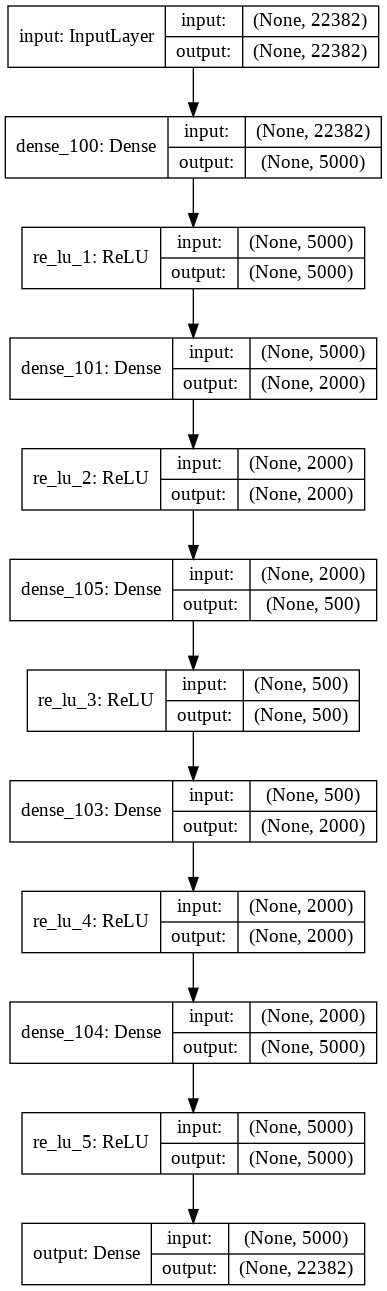

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(autoencoder, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
seed

88888


Epoch 1/160
1440/1440 [==============================] - 15s 10ms/step - loss: 0.0549 - accuracy: 0.0021
Epoch 2/160
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0070 - accuracy: 0.0153
Epoch 3/160
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0068 - accuracy: 0.0549
Epoch 4/160
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0065 - accuracy: 0.0465
Epoch 5/160
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0057 - accuracy: 0.0222
Epoch 6/160
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0052 - accuracy: 0.0417
Epoch 7/160
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0051 - accuracy: 0.0403
Epoch 8/160
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0050 - accuracy: 0.0174
Epoch 9/160
1440/1440 [==============================] - 13s 9ms/step - loss: 0.0048 - accuracy: 0.0104
Epoch 10/160
1440/1440 [==============================] - 13s 

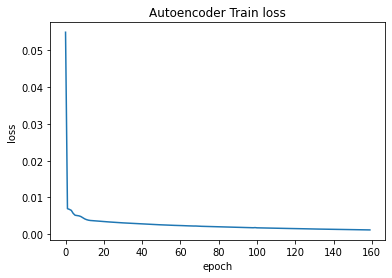

In [ ]:
adam=Adam(lr=0.00003) 
autoencoder.compile(optimizer=adam, loss='mean_squared_error',metrics=['accuracy']) 
#es = EarlyStopping(monitor='val_loss', min_delta = 0.001, mode='min', verbose=1,patience=50)

numIterations = 160     

history=autoencoder.fit(X_train_sm, X_train_sm,
                epochs=numIterations,
                batch_size=32, 
                shuffle=True,
                #validation_data=(X_val, X_val),  
                #callbacks=[es]
                )

plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Autoencoder Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper right')
#plt.savefig('results/autoencoder_loss.png')

plt.show()

In [ ]:
B=autoencoder.predict(X_train)
print("\nTraining Error %s: %.5f" % (autoencoder.metrics_names[1], (np.square(X_train-B)).mean(axis=None)))
#B=autoencoder.predict(X_val)
#print("\nValidation Error %s: %.5f" % (autoencoder.metrics_names[1], (np.square(X_val-B)).mean(axis=None)))
B=autoencoder.predict(X_test)
print("\nTesting Error %s: %.5f" % (autoencoder.metrics_names[1], (np.square(X_test-B)).mean(axis=None))

In [ ]:
encoder=Model(inputs=input_layer1,outputs=relu3)
print(encoder.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22382)             0         
_________________________________________________________________
dense_100 (Dense)            (None, 5000)              111915000 
_________________________________________________________________
re_lu_1 (ReLU)               (None, 5000)              0         
_________________________________________________________________
dense_101 (Dense)            (None, 2000)              10002000  
_________________________________________________________________
re_lu_2 (ReLU)               (None, 2000)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 500)               1000500   
_________________________________________________________________
re_lu_3 (ReLU)               (None, 500)               0   

In [ ]:
model_json=encoder.to_json()
with open("results/encoder_seed"+str(seed)+".json","w") as json_file:
  json_file.write(model_json)
encoder.save_weights("results/encoder_seed"+str(seed)+".h5") 

In [ ]:
model_json=autoencoder.to_json()
with open("results/autoencoder"+str(seed)+".json","w") as json_file:
  json_file.write(model_json) 